# Autonomous Driving Rover
**Leonardo Russo 2015563**

### Introduction

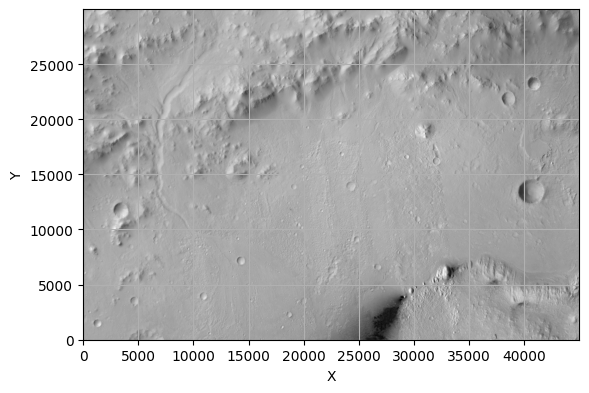

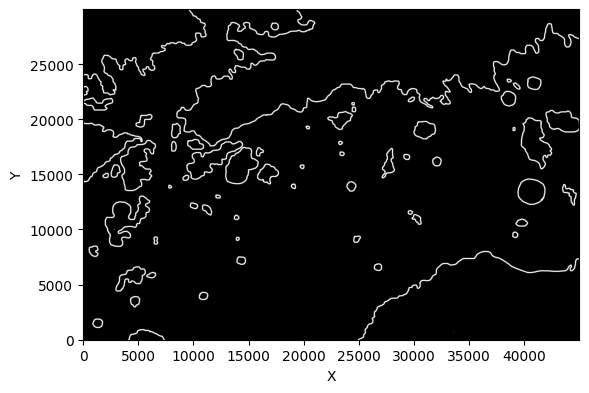

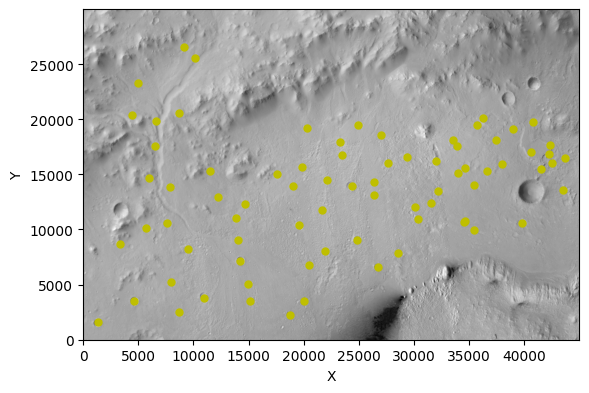

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import library as lib
from scipy.integrate import solve_ivp
import pickle
import os
import sympy as sp
from tqdm import tqdm
from pprint import pprint

# from rich.traceback import install
# install(show_locals = True)

# Set Options
np.set_printoptions(precision=4)


X, Y, map_image, obstacleMap, xLM, yLM, Xvec, Yvec = lib.load_data()

# Define Map Resolution
mapRes = 10     # meters per pixel

# Squeeze Xvec and Yvec -> both these variables must be one-dimensional vectors
Xvec = np.squeeze(Xvec)
Yvec = np.squeeze(Yvec)

# Define Physical Values
L = 3           # m - axles distance
v_max = 4e-2    # m/s - max speed

# Define Specific Poses
P0 = np.array([42.38*1e3, 11.59*1e3, np.pi/2])          # m, m, rad
P1 = np.array([33.07*1e3, 19.01*1e3, np.pi])            # m, m, rad

# Show Original Map
plt.figure()
lib.plot_map(map_image, Xvec, Yvec)
plt.show()

# Obstacle map in grayscale
plt.figure()
plt.imshow(obstacleMap, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Landmarks on grayscale map
plt.figure()
plt.imshow(map_image, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot(xLM, yLM, 'yo', markersize=5, linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

**Find specific Landmarks**

In [19]:
# xguess = 41000
# yguess = 16000
# tol = 1000
# counter = 0

# for xlm, ylm in zip(xLM, yLM):
    
#     if abs(xguess - xlm) < tol and abs(yguess - ylm) < tol:

#         counter += 1
#         break

# print(xlm == xLM)
# print(counter)
# print(xLM[0], yLM[0])

**Test the Coordinate Conversion**

In [20]:
# Compute Relative States
R0 = lib.P2R(P0, P1)
R1 = lib.P2R(P1, P1)

# Convert backwards the Relative State into Pose State
P0p = lib.R2P(R0, P1)

print('\nThe Initial Pose State is P0:\n', P0)
print('\nThe Relative Pose State is R0:\n', R0)
print("\nThe Backconverted Initial Pose State is P0':\n", P0p)


The Initial Pose State is P0:
 [4.2380e+04 1.1590e+04 1.5708e+00]

The Relative Pose State is R0:
 [1.1905e+04 8.9789e-01 6.7290e-01]

The Backconverted Initial Pose State is P0':
 [4.2380e+04 1.1590e+04 1.5708e+00]


### Task 1: Navigation - Moving to a Pose

The first task requires the Rover to reach a first new pose using the Moving to a Pose control law.

The gains were selected as follows:
`K = [1e-4, 1.4e-3, -1.8e-3]`


Task 1
______________________________________________________________________ 

The Initial State is:	 [4.2380e+04 1.1590e+04 1.5708e+00]
The Final State is:	 [3.3070e+04 1.9010e+04 3.1416e+00]
The Desired State is:	 [3.3070e+04 1.9010e+04 3.1416e+00]

The Delta State is:	 [1.0001e-01 1.2726e-08 1.7067e-06]
Final Time is:		 4.68 days


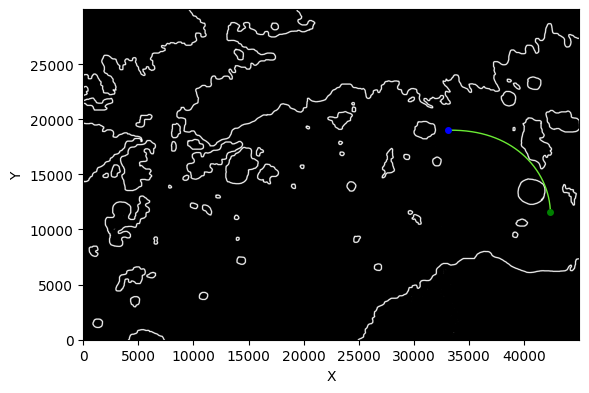

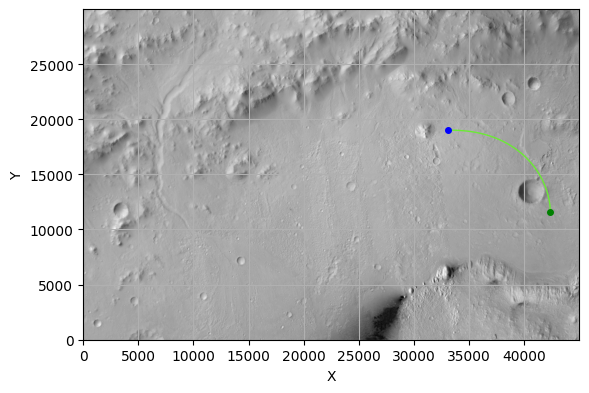

In [21]:
# Define the event function
rho_tol = 0.1    # m
def event(t, R):
    return R[0] - rho_tol
event.terminal = True

# Define Initial Relative State
R0 = lib.P2R(P0, P1)

# Define Time Domain
t0 = 0                                  # sec - initial start time
tf = lib.days2sec(30)                   # sec - max manoeuvre time
freq = 1                                # Hz - trajectory sampling frequency
tspan = np.arange(t0, tf+1, 1/freq)     # tspan generation at given sampling frequency


# Select Gains
K = np.array([1e-4, 1.4e-3, -1.8e-3])

# Solve the differential equation
sol = solve_ivp(lambda t, R: lib.KinematicModel(t, R, K), [t0, tf], R0, method='RK45', t_eval=tspan, events=event)
tspan = sol.t
R = sol.y
P = lib.R2P(R, P1)

# Check for Obstacles
P_indices = np.array([lib.get_indices(P[0:2, i], X, Y, mapRes) for i in range(P.shape[1])])    # convert each point in the trajectory to map indices

if lib.check_obstacles(P_indices, obstacleMap):
    print('\n\nThe Trajectory intersects with an Obstacle!\n\n')

P1r = P[:, -1]      # store the real final state


# Log Results
print('\nTask 1\n' + '_'*70, '\n\nThe Initial State is:\t', P0)
print('The Final State is:\t', P[:, -1])
print('The Desired State is:\t', P1)
print('\nThe Delta State is:\t', P[:, -1] - P1)
print('Final Time is:\t\t {:.2f} days'.format(lib.sec2days(tspan[-1])))

# Obstacle map in grayscale
plt.figure()
plt.imshow(obstacleMap, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot(P[0, :], P[1, :], '#6beb34', linestyle='-', linewidth=1)
plt.plot(P0[0], P0[1], 'go', markersize=4)
plt.plot(P1[0], P1[1], 'bo', markersize=4)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Show Trajectory
plt.figure("Task 1 - Trajectory")
lib.plot_map(map_image, Xvec, Yvec)
plt.plot(P[0, :], P[1, :], '#6beb34', linestyle='-', linewidth=1)
plt.plot(P0[0], P0[1], 'go', markersize=4)
plt.plot(P1[0], P1[1], 'bo', markersize=4)
plt.show()




### Task 2: Path Planning - A* Algorithm

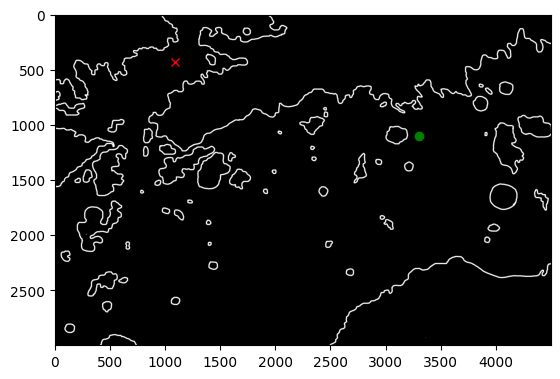

In [22]:
# Define Start and End Coordinates
start = P1r[0:2]
end = np.array([10.87e3, 25.67e3])

start = lib.get_indices(start, X, Y, mapRes)
end = lib.get_indices(end, X, Y, mapRes)
# end = np.array([1500, 750])

# Obstacle map in grayscale
plt.figure("Task 1 - Trajectory")
plt.imshow(obstacleMap, cmap='gray')
plt.plot([start[1]], [start[0]], c='green', marker='o')
plt.plot([end[1]], [end[0]], c='red', marker='x')
plt.show()

#### Define the Algorithm Function

In [23]:
def A_star(start, end, obstacle_map):
    class Node:
        def __init__(self, position, parent):
            self.position = tuple(position)  # Store position as a tuple
            self.parent = parent
            self.g = 0  # Distance to start node
            self.h = 0  # Distance to goal node
            self.f = 0  # Total cost

        def __eq__(self, other):
            return self.position == other.position

        def __hash__(self):
            return hash(self.position)  # Hash based on position for use in sets

    # Heuristic function for distance
    def heuristic(a, b):
        return max(abs(a[0]-b[0]), abs(a[1]-b[1])) + 0.41421356237 * min(abs(a[0]-b[0]), abs(a[1]-b[1]))

    open_list = []
    closed_list_set = set()

    start_node = Node(start, None)
    end_node = Node(end, None)
    open_list.append(start_node)

    while len(open_list) > 0:
        current_node = min(open_list, key=lambda node: node.f)
        open_list.remove(current_node)
        closed_list_set.add(current_node)

        if current_node.position == end_node.position:
            path = []
            while current_node:
                path.append(current_node.position)
                current_node = current_node.parent
            return path[::-1]  # Return reversed path

        # Generate children
        (x, y) = current_node.position
        neighbors = [(x, y-1), (x-1, y-1), (x-1, y), (x-1, y+1), (x, y+1), (x+1, y+1), (x+1, y), (x+1, y-1)]

        for next_node in neighbors:
            # Make sure within range
            if next_node[0] > (len(obstacle_map) - 1) or next_node[0] < 0 or next_node[1] > (len(obstacle_map[0]) - 1) or next_node[1] < 0:
                continue

            # Make sure walkable terrain
            if int(obstacle_map[next_node[0]][next_node[1]]) == 255:  # Convert to int for comparison
                continue

            # Create new node
            neighbor = Node(next_node, current_node)

            # Check if the neighbor is in the closed list
            if neighbor in closed_list_set:
                continue

            # Create the f, g, and h values
            neighbor.g = current_node.g + 1
            neighbor.h = heuristic(neighbor.position, end_node.position)
            neighbor.f = neighbor.g + neighbor.h

            # Check if neighbor is in open list and if it has a lower f value
            if add_to_open(open_list, neighbor):
                open_list.append(neighbor)

    return None  # No path found

# Function to check if a neighbor should be added to the open list
def add_to_open(open_list, neighbor):
    for node in open_list:
        if neighbor == node and neighbor.f >= node.f:
            return False
    return True


#### Compute the Path

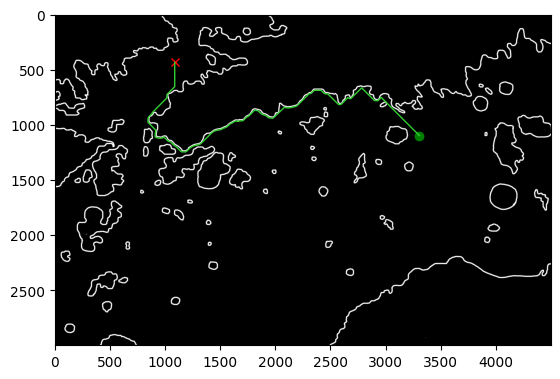

In [24]:
# Define Path location
path_filepath = os.path.join('Data', 'path.pkl')

if os.path.exists(path_filepath):
    with open(path_filepath, 'rb') as file:         # load path variable from Data
        path = pickle.load(file)

else:
    path = A_star(start, end, obstacleMap)          # find the path using A* algorithm
    path = np.array(path)                           # convert to numpy matrix

    with open('Data/path.pkl', 'wb') as file:       # save path variable to Data
        pickle.dump(path, file)


# Plot the Path
plt.figure("Task 2 - Pathfinding")
plt.imshow(obstacleMap, cmap='gray')
plt.plot([start[1]], [start[0]], c='green', marker='o')
plt.plot([end[1]], [end[0]], c='red', marker='x')
plt.plot(path[:, 1], path[:, 0], c='limegreen', linestyle='-', linewidth=1)
plt.show()

### Task 3: Rover Localization - EKF

#### Define Problem Parameters

In [25]:
# Retrieve Trajectory from Task 1
q_real = P.T            # N x 3 matrix containing the real pose state at each time step
tspan_real = tspan      # N x 1 array containing state's timespan

# Define Model Parameters
sigma_x = 6                         # m
sigma_y = 6                         # m
sigma_theta = np.deg2rad(1)         # rad

# Define Initial Covariance Matrix
P0 = np.array([[sigma_x**2, 0, 0], [0, sigma_y**2, 0], [0, 0, sigma_theta**2]])

# Define Sensor Parameters
sigma_d = 4e-3                      # m
sigma_theta = np.deg2rad(0.05)      # rad


#### Define Observable Functions

##### $z = h(q, lm) \qquad \qquad H_q = \frac{\partial h}{\partial q}$

In [26]:
def h(q, x_lm, y_lm):
    '''
    Description: this function computes the observables from the state variable and the landmark position.
    '''

    range = np.linalg.norm([x_lm - q[0], y_lm - q[1]])
    bearing_angle = np.arctan2(y_lm - q[1], x_lm - q[0]) - q[2]

    return np.array([range, float(np.squeeze(bearing_angle))])

def get_Hq(q, lm):
    '''
    Description: this expression was found from an analytical standpoint using symbolic tools.
    '''

    x, y = q.item(0), q.item(1)
    xlm, ylm = np.squeeze(lm)[0:2]

    Hq = np.array([
        [np.abs(x-xlm)*np.sign(x-xlm)/(np.sqrt((x-xlm)**2 + (y-ylm)**2)), np.abs(y-ylm)*np.sign(y-ylm)/(np.sqrt((x-xlm)**2 + (y-ylm)**2)), 0], 
        [-(y-ylm)/((x-xlm)**2 + (y-ylm)**2), (x-xlm)/((x-xlm)**2 + (y-ylm)**2), -1]
        ])
    
    return Hq


#### Perform the Trajectory Reconstruction

Reconstructing Trajectory: 100%|██████████| 404673/404673 [03:54<00:00, 1728.10it/s]


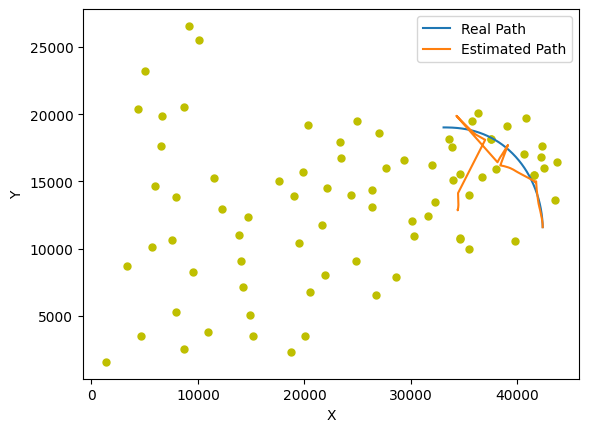

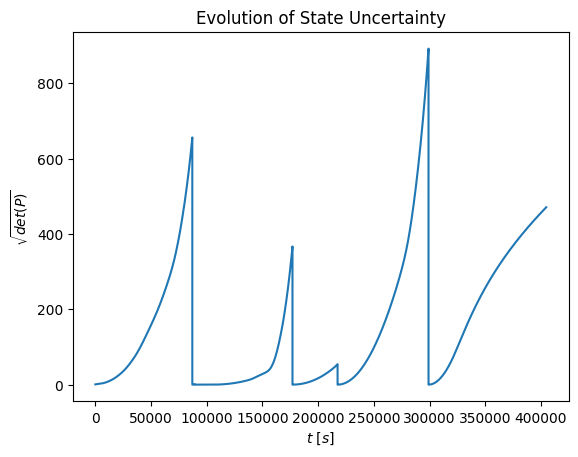

In [28]:
def trajectory_reconstruction(q_real, sigma_d, sigma_theta, lidar_maxrange=500, sigma_r=10e-2, sigma_beta=np.deg2rad(0.25)):
    
    q_est = [q_real[0]]     # initialize the estimated trajectory
    P_est = [P0]            # initialize covariance matrix

    # Create measurement Covariance Matrix
    V = np.array([[sigma_d**2, 0], [0, sigma_theta**2]])

    for i in tqdm(range(1, len(q_real)), desc="Reconstructing Trajectory"):

        # Compute the odometry measurements in distance and orientation
        delta_d = np.linalg.norm(q_real[i][:2] - q_real[i-1][:2])           # delta in distance
        delta_theta = q_real[i][2] - q_real[i-1][2]                         # delta in orientation

        # Add noise to the odometry measurements
        delta_d = delta_d + np.random.normal(0, sigma_d)
        delta_theta = delta_theta + np.random.normal(0, sigma_theta)

        # Retrieve last State and Covariance matrix
        x, y, theta = q_est[-1]
        P = P_est[-1]

        # Estimate the new State
        x_new = x + delta_d*np.cos(theta)
        y_new = y + delta_d*np.sin(theta)
        theta_new = theta + delta_theta
        q_new = np.array([x_new, y_new, theta_new])

        # Estimate the new Covariance Matrix
        Fq = np.array([[1, 0, -delta_d*np.sin(theta)], [0, 1, delta_d*np.cos(theta)], [0, 0, 1]])
        Fv = np.array([[np.cos(theta), 0], [np.sin(theta), 0], [0, 1]])
        P_new = Fq @ P @ Fq.T + Fv @ V @ Fv.T


        # Check for visible Landmarks
        for x_lm, y_lm in zip(xLM, yLM):

            dist_lm = np.linalg.norm([x_lm - x_new, y_lm - y_new])

            if dist_lm <= lidar_maxrange:
              
                # Compute the Observables from the real State -> observables that I should see
                z_real = h(q_real[i], x_lm, y_lm) + np.array([np.random.normal(0, sigma_r), np.random.normal(0, sigma_beta)])
                z_new = h(q_new, x_lm, y_lm)

                # Compute Kalman Gain
                Hq = get_Hq(q_new, (x_lm, y_lm))
                Hw = np.array([[1, 0], [0, 1]])
                W = np.array([[sigma_r**2, 0], [0, sigma_beta**2]])
                K = P_new @ Hq.T @ np.linalg.inv(Hq @ P_new @ Hq.T + Hw @ W @ Hw.T)

                # Perform State Update
                innovation = z_real - z_new
                q_upd = K @ innovation
                q_new = q_new + q_upd
                P_new = (np.eye(3) - K @ Hq) @ P_new

                # print('\nPerforming EKF @ step {:.0f}:\nq_est = '.format(i), q_new, '\nq_upd = ', q_upd)

                # break
                

        # Append the new estimated position and orientation
        q_est.append(q_new)
        P_est.append(P_new)

    return np.array(q_est), P_est


# Compute Reconstructed Trajectory
q_est, P_est = trajectory_reconstruction(q_real, sigma_d=4e-3, sigma_theta=np.deg2rad(0.05))

# Compute the square root of the determinant of each Covariance matrix
sqrt_det_P = [np.sqrt(np.linalg.det(P)) for P in P_est]


# Visualize the Estimated Trajectory
plt.figure("Task 3 - Rover Localization")
# lib.plot_map(map_image, Xvec, Yvec)
plt.plot(xLM, yLM, 'yo', markersize=5, linewidth=2)
plt.plot(xLM[12], yLM[12], 'yo', markersize=5, linewidth=2)
plt.plot(xLM[0], yLM[0], 'yo', markersize=5, linewidth=2)
plt.plot(q_real[:, 0], q_real[:, 1], label='Real Path')
plt.plot(q_est[:, 0], q_est[:, 1], label='Estimated Path')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

# Visualize the Covariance Matrix Evolution
plt.figure("Covariance Matrix Evolution")
plt.plot(tspan, sqrt_det_P)
plt.xlabel('$t \ [s]$')
plt.ylabel('$\sqrt{det(P)}$')
plt.title('Evolution of State Uncertainty')
plt.show()

# Ideas:
# Set the required landmarks at the beginning of the array to speed up the EKF process
